In [7]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

In [2]:
# 加入argument parsing
args = {
      'ckptpath': './checkpoint.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

In [16]:
# 封装数据集
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'
        
        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 便于获得指定图片集合，作为一个batch
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

In [14]:
# 定义model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        def building_block(indim, outdim):
              return [
                nn.Conv2d(indim, outdim, 3, 1, 1),
                nn.BatchNorm2d(outdim),
                nn.ReLU(),
              ]
        def stack_blocks(indim, outdim, block_num):
            layers = building_block(indim, outdim)
            for i in range(block_num - 1):
                layers += building_block(outdim, outdim)
            layers.append(nn.MaxPool2d(2, 2, 0))
            return layers

        cnn_list = []
        cnn_list += stack_blocks(3, 128, 3)
        cnn_list += stack_blocks(128, 128, 3)
        cnn_list += stack_blocks(128, 256, 3)
        cnn_list += stack_blocks(256, 512, 1)
        cnn_list += stack_blocks(512, 512, 1)
        self.cnn = nn.Sequential( * cnn_list)

        dnn_list = [
          nn.Linear(512 * 4 * 4, 1024),
          nn.ReLU(),
          nn.Dropout(p = 0.3),
          nn.Linear(1024, 11),
        ]
        self.fc = nn.Sequential( * dnn_list)

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fc(out)

In [9]:
#载入模型参数
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [12]:
# 拿到数据
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

#封装数据
train_set = FoodDataset(train_paths, train_labels, mode='eval')

In [13]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

### Saliency Map

In [18]:
def compute_saliency_maps(x, y, model):
    model.eval()
    x = x.cuda()
    # input x需要gradient
    x.requires_grad_()
    y_pred = model(x)
    #定义损失函数
    loss_func = torch.nn.CrossEntropyLoss()
    #计算loss
    loss = loss_func(y_pred,y.cuda())
    #回传
    loss.backward()
    saliencies = x.grad.abs().detach().cpu()
    saliencies = torch.stack([normalize(item) for item in saliencies])#（batches,channels,height,weight)
    return saliencies

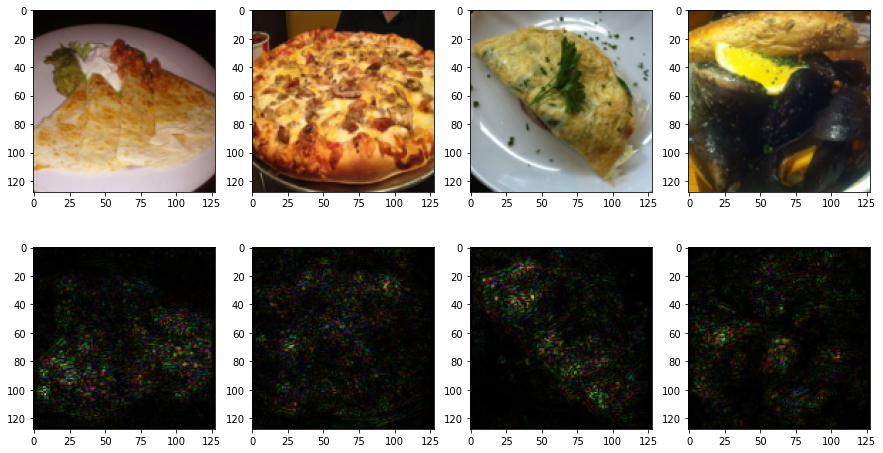

In [19]:
# 指定要可视化的图片的下标
img_indices = [50, 421, 4500, 8000]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

#通过matplotlib画出来
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
    for column, img in enumerate(target):
        axs[row][column].imshow(img.permute(1, 2, 0).numpy())#(channels, height, width)转换为(height, width, channels)
        
plt.show()
plt.close()

### Filter Explaination

In [20]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [21]:
layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
    model.eval()
    def hook(model,input,output):
        global layer_activations
        layer_activations = output
    # hook:forward both loss and activation map
    hook_handle = model.cnn[cnnid].register_forward_hook(hook)
    # filter activation
    model(x.cuda())
    filter_activations = layer_activations[:,filterid,:,:].detach().cpu()
    # filter visualization
    x = x.cuda()
    x.requires_grad_()
    optimizer = Adam([x],lr=lr)
    for iter in range(iteration):
        optimizer.zero_grad()
        model(x)
        objective = -layer_activations[:,filterid,:,:].sum()
        objective.backward()
        optimizer.step()
        
    filter_visualization = x.detach().cpu().squeeze()[0]
    hook_handle.remove()
    return filter_activations,filter_visualization

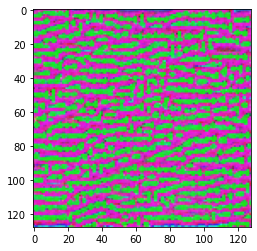

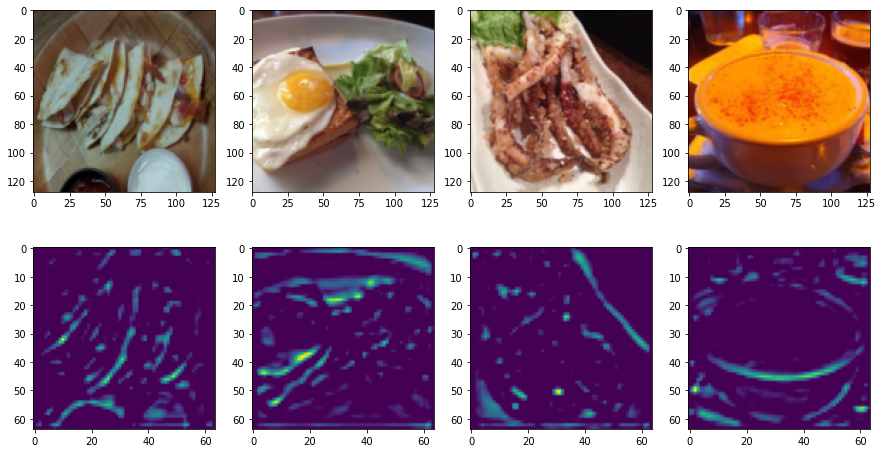

In [22]:
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualization = filter_explaination(images, model, cnnid=15, filterid=0, iteration=100, lr=0.1)

# 畫出 filter visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()
plt.close()
# 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
# 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

# 畫出 filter activations
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
plt.show()
plt.close()
# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

### Lime

In [ ]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)                                                                                                                                                         
    model.eval()        
    with torch.no_grad():
        input = torch.FloatTensor(input).permute(0, 3, 1, 2)                                                                                                            
        # (batches, channels, height, width)
        output = model(input.cuda())                                                                                                                                             
    return output.detach().cpu().numpy()                                                                                                                              
                                                                                                                                                                             
def segmentation(input):                                                                                                                                    
    return slic(input, n_segments=100, compactness=1, sigma=1)                                                                                                              
                                                                                                                                                                             
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):          
    with torch.no_grad():
        x = image.astype(np.double)
        # lime 这个套件需要Numpy array
        explainer = lime_image.LimeImageExplainer()                                                                                                                              
        explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
        # classifier_fn 定义图片如何经过 model 得到 prediction
        # segmentation_fn 定义如何把图片做 segmentation
        lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                    label=label.item(),                                                                                                                           
                                    positive_only=False,                                                                                                                         
                                    hide_rest=False,                                                                                                                             
                                    num_features=11,                                                                                                                              
                                    min_weight=0.05                                                                                                                              
                                )
        axs[idx].imshow(lime_img)

plt.show()
plt.close()